# Predictive methode to predict the use of TelCom in Milano, one step at a time


Here, we use Keras with a tensorflow backend to predict the use of telcom at timestamp t+10 minutes from the data at timestamp t, using an LSTM unit.

Inspiration : Jason Brownlee in [this tutorial](https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/)




In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
from src.preprocess_tools import *
import os
import math
np.random.seed(1)

In [108]:
# file = 'data/MI_squares/5560/5560_all.csv'
# d = pd.read_csv(file, sep = '\t')
# d.head(2)

### a) Basés sur notre inspiration, nous transformons les TS pour un usage supervisé.



In [109]:
from sklearn.preprocessing import MinMaxScaler
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

def cycle_theta(t,freq):
    return(2*math.pi*(t/float(freq-1)))
def cycle_of_time(t, freq,func = math.cos):
    return func(cycle_theta(t,freq))
def isweekend(Wday):
    if Wday<=4:
        return 0
    else:
        return 1
# load dataset
file = 'data/MI_squares/5561/5561_all.csv'
dataset = pd.read_csv(file, sep = '\t')
dataset.drop("Square",axis=1,inplace=True)
dataset.set_index("Time",inplace=True)

dataset["Monthcos"] = dataset["Month"].apply(lambda x : cycle_of_time(x,12))
dataset["Monthsin"] = dataset["Month"].apply(lambda x : cycle_of_time(x,12,func = math.sin))
dataset["Hourcos"] = dataset["Hour"].apply(lambda x : cycle_of_time(x,24))
dataset["Hoursin"] = dataset["Hour"].apply(lambda x : cycle_of_time(x,24,func = math.sin))
dataset["WEnd"] = dataset["WDay"].apply(isweekend)
dataset["WDaycos"] = dataset["WDay"].apply(lambda x : cycle_of_time(x,7))
dataset["WDaysin"] = dataset["WDay"].apply(lambda x : cycle_of_time(x,7,func=math.sin))
dataset = dataset.drop(["Month","Hour","WDay","Day"],axis=1)

# On met les données en dernières colonnes
col = dataset.columns.tolist()
new_col =  col[5:]+col[:5]
dataset = dataset[new_col]


values = dataset.values
# # integer encode direction
# encoder = LabelEncoder()
# values[:,4] = encoder.fit_transform(values[:,4])

# ensure all data is float
values = values.astype('float32')

In [111]:
n_predictors = 8

In [112]:
# normalize features
scaler = MinMaxScaler(feature_range=(0, 1))
scaled = scaler.fit_transform(values)
# frame as supervised learning
reframed = series_to_supervised(scaled, 1, 1)
# drop columns we don't want to predict (i.e. hour, etc)
last_col = reframed.shape[1]-1
# reframed.drop(reframed.columns[[last_col,last_col-1,last_col-2,last_col-3,last_col-4]], axis=1, inplace=True)
reframed.drop(["var"+str(i)+"(t)" for i in np.arange(1,n_predictors+1)],axis=1,inplace=True)
reframed.head()

,var1(t-1),var2(t-1),var3(t-1),var4(t-1),var5(t-1),var6(t-1),var7(t-1),var8(t-1),var9(t-1),var10(t-1),var11(t-1),var12(t-1),var13(t-1),var9(t),var10(t),var11(t),var12(t),var13(t)
1,0.0,0.0,0.0,1.0,0.5,0.0,0.0,0.5,0.318109,0.063682,0.139302,0.148591,0.179242,0.163400,0.090886,0.110716,0.115232,0.225252
2,0.0,0.0,0.0,1.0,0.5,0.0,0.0,0.5,0.163400,0.090886,0.110716,0.115232,0.225252,0.174412,0.056188,0.148020,0.075459,0.218824
3,0.0,0.0,0.0,1.0,0.5,0.0,0.0,0.5,0.174412,0.056188,0.148020,0.075459,0.218824,0.160536,0.065231,0.159852,0.153067,0.223483
4,0.0,0.0,0.0,1.0,0.5,0.0,0.0,0.5,0.160536,0.065231,0.159852,0.153067,0.223483,0.159054,0.083870,0.095243,0.067691,0.212521
5,0.0,0.0,0.0,1.0,0.5,0.0,0.0,0.5,0.159054,0.083870,0.095243,0.067691,0.212521,0.253128,0.069255,0.049292,0.073836,0.250204


### b) On divise en jeu train et jeu validation 

In [114]:
values = reframed.values
n_ten_min = int((6*24*60)*0.85) #85% vs 15% 
train = values[:n_ten_min, :]
test = values[n_ten_min:, :]
# split into input and outputs
train_X, train_y = train[:,:-5], train[:, -5:]
test_X, test_y = test[:, :-5], test[:, -5:]
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(7344, 1, 13) (7344, 5) (1583, 1, 13) (1583, 5)


### c) On importe keras, définissons notre architecture et entraînons le modèle

In [115]:
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# design network
model = Sequential()
# model.add(LSTM(60, input_shape=(train_X.shape[1], train_X.shape[2]),return_sequences=True))
# model.add(Dropout(0.2))
model.add(LSTM(60, input_shape=(train_X.shape[1], train_X.shape[2]),return_sequences=False))

model.add(Dense(20, activation = "relu"))
model.add(Dense(5, activation = "relu"))
model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs=12, batch_size=100, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Train on 7344 samples, validate on 1583 samples
Epoch 1/12
2s - loss: 0.1380 - val_loss: 0.0652
Epoch 2/12
0s - loss: 0.1034 - val_loss: 0.0534
Epoch 3/12
0s - loss: 0.0893 - val_loss: 0.0518
Epoch 4/12
0s - loss: 0.0865 - val_loss: 0.0519
Epoch 5/12
0s - loss: 0.0855 - val_loss: 0.0514
Epoch 6/12
0s - loss: 0.0851 - val_loss: 0.0513
Epoch 7/12
0s - loss: 0.0849 - val_loss: 0.0510
Epoch 8/12
0s - loss: 0.0847 - val_loss: 0.0507
Epoch 9/12
0s - loss: 0.0844 - val_loss: 0.0506
Epoch 10/12
0s - loss: 0.0843 - val_loss: 0.0504
Epoch 11/12
0s - loss: 0.0841 - val_loss: 0.0505
Epoch 12/12
0s - loss: 0.0838 - val_loss: 0.0505


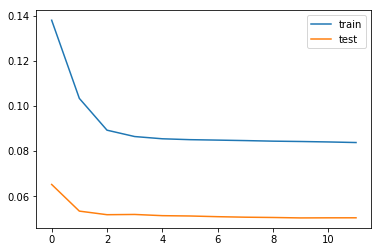

In [116]:
# plot history
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='test')
plt.legend()
plt.show()

### d) Evaluation du modèle

In [120]:
dataset.columns, test_X.shape,test_X_reshaped.shape, inv_yhat.shape

(Index(['Charge', 'Monthcos', 'Monthsin', 'Hourcos', 'Hoursin', 'WEnd',
        'WDaycos', 'WDaysin', 'SMSin', 'SMSout', 'Callin', 'Callout',
        'Internet'],
       dtype='object'), (1583, 1, 13), (1583, 13), (1583,))

In [133]:
# test_X_reshaped[0]
values[0]

array([ 0.        ,  0.        ,  0.        ,  1.        ,  0.5       ,
        0.        ,  0.        ,  0.49999997,  0.31810877,  0.06368174,
        0.13930164,  0.14859116,  0.17924237,  0.16340002,  0.0908862 ,
        0.11071601,  0.11523228,  0.22525215], dtype=float32)

In [140]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
forecast = []
ground_truth = []
for index, name in enumerate(dataset.columns[-5:]): 
    col_index = index+n_predictors
    yhat = model.predict(test_X)
    test_X_reshaped = test_X.reshape((test_X.shape[0], test_X.shape[2]))
    #forecast
    inv_yhat = np.concatenate((test_X_reshaped[:,:-5],yhat), axis=1)
    inv_yhat = scaler.inverse_transform(inv_yhat)
    inv_yhat = inv_yhat[:,col_index]
    inv_yhat = np.clip(inv_yhat,0,None)
    forecast.append(inv_yhat)
    #ground truth
    inv_y = np.concatenate((test_X_reshaped[:, :-5],test_y), axis=1)
    inv_y = scaler.inverse_transform(inv_y)
    inv_y = inv_y[:,col_index]
    ground_truth.append(inv_y)
    # calculate RMSE
    rmse = math.sqrt(mean_squared_error(inv_y, inv_yhat))
    mae = mean_absolute_error(inv_y,inv_yhat)
    print(name +' - RMSE=%.3f and MAE=%.3f' % (rmse,mae))

SMSin - RMSE=2.696 and MAE=1.877
SMSout - RMSE=2.805 and MAE=1.951
Callin - RMSE=4.859 and MAE=3.220
Callout - RMSE=2.726 and MAE=2.006
Internet - RMSE=16.875 and MAE=13.235


### e) Visualisation

e) 1) Whole data

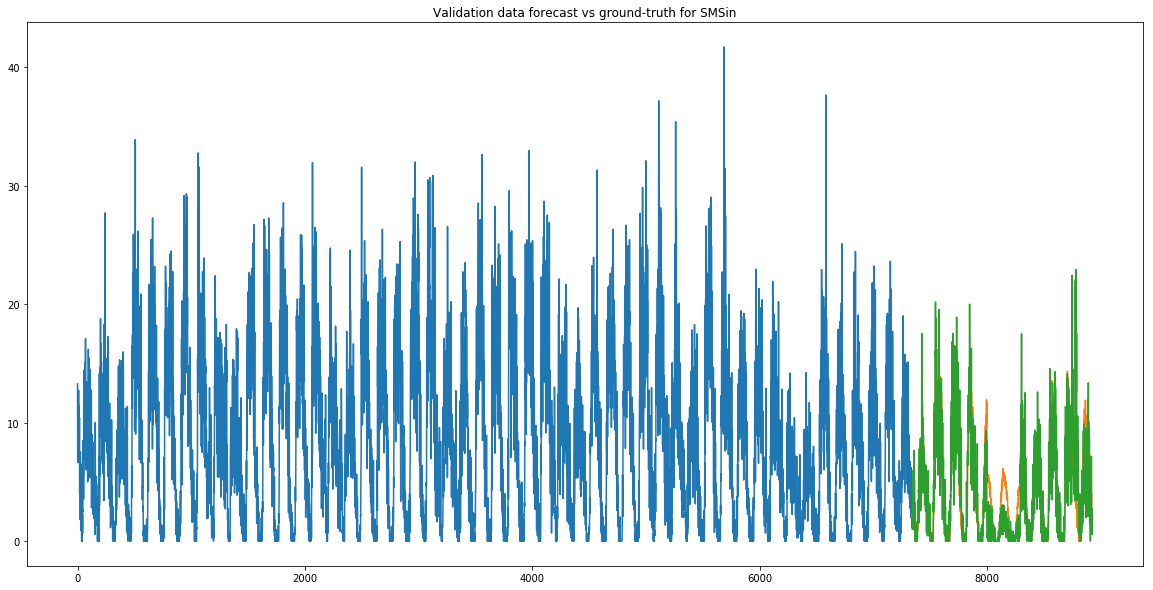

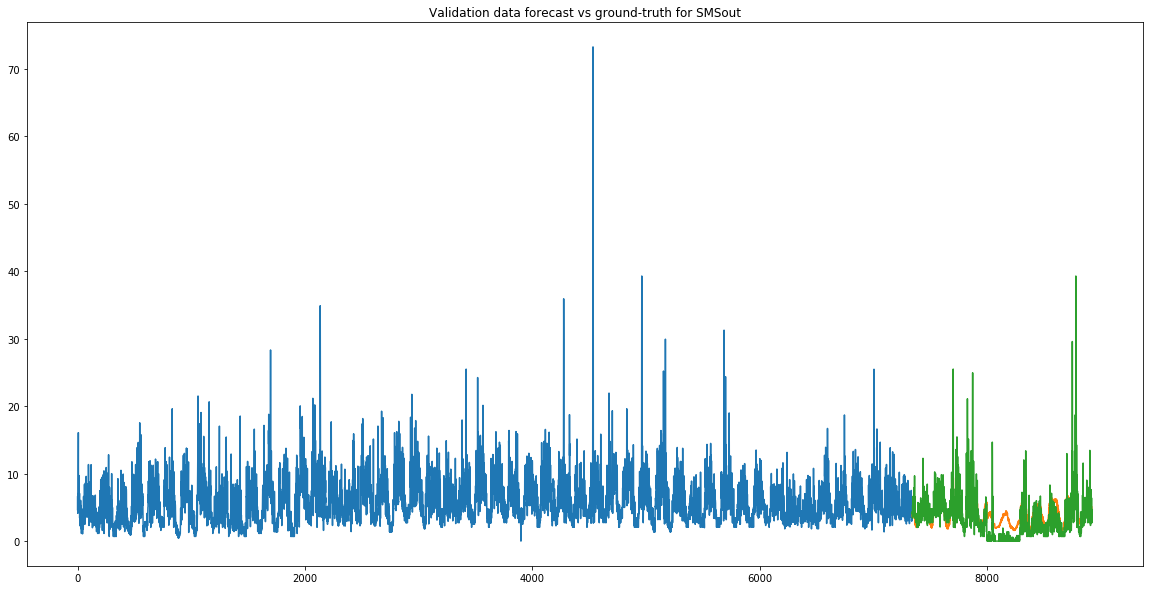

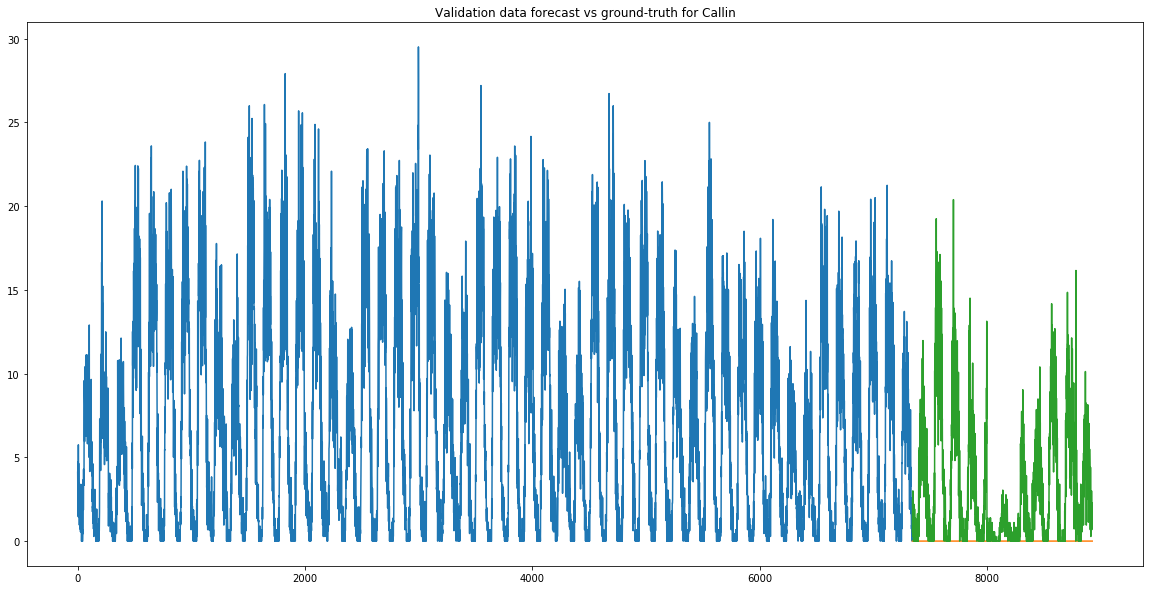

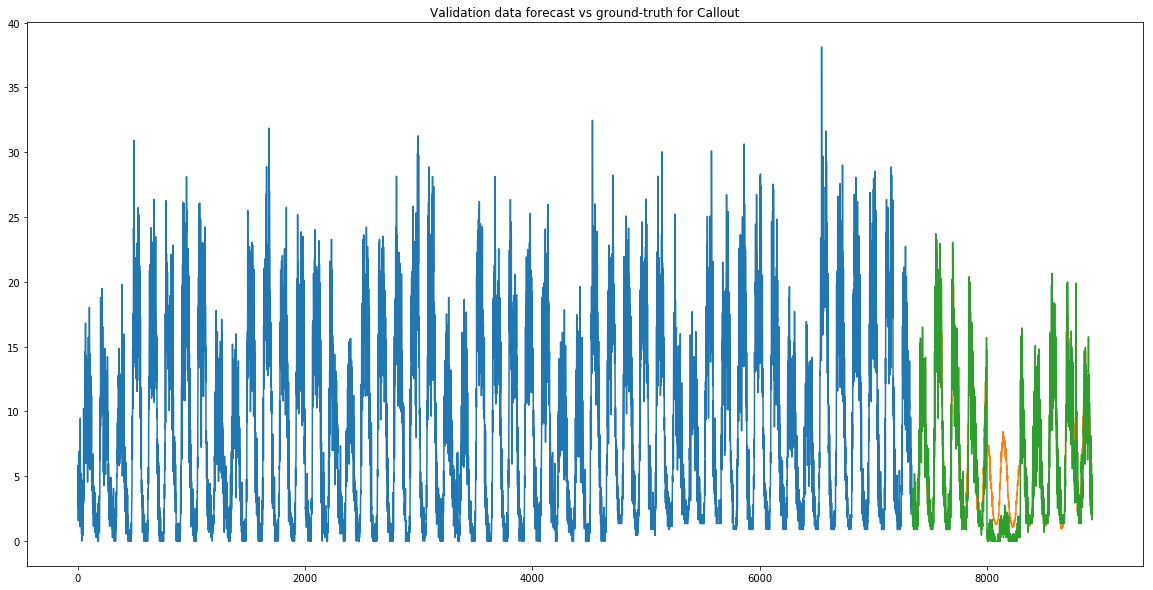

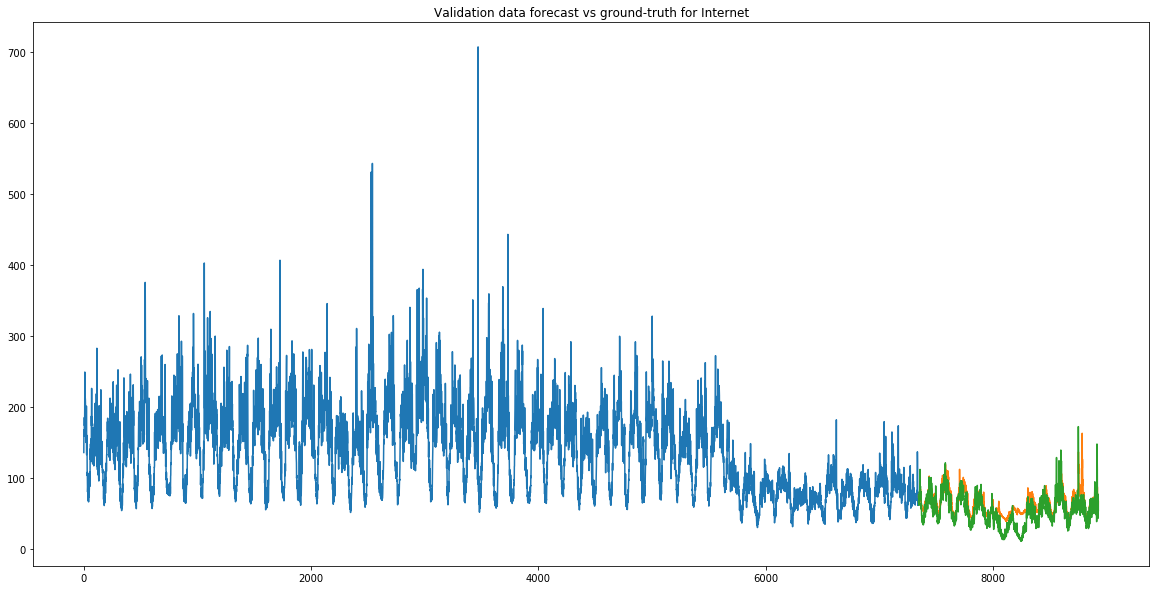

In [141]:
# reframed.plot(y = reframed.columns[-5:])
# reframed.columns
# n_ten_min
# dataset.values[["SMSin","SMSout","Callin","Callout","Internet"]]
ground_train = dataset[["SMSin","SMSout","Callin","Callout","Internet"]].values[:n_ten_min,:]
for i, name in enumerate(["SMSin","SMSout","Callin","Callout","Internet"]) :
    plt.figure(figsize = (20,10))
    plt.plot(np.arange(train_y.shape[0]),ground_train[:,i])
    plt.plot(np.arange(train_y.shape[0],train_y.shape[0]+inv_yhat.shape[0]),forecast[i])
    plt.plot(np.arange(train_y.shape[0],train_y.shape[0]+inv_yhat.shape[0]),ground_truth[i])
    plt.title("Validation data forecast vs ground-truth for " + name)

e) 2) detail

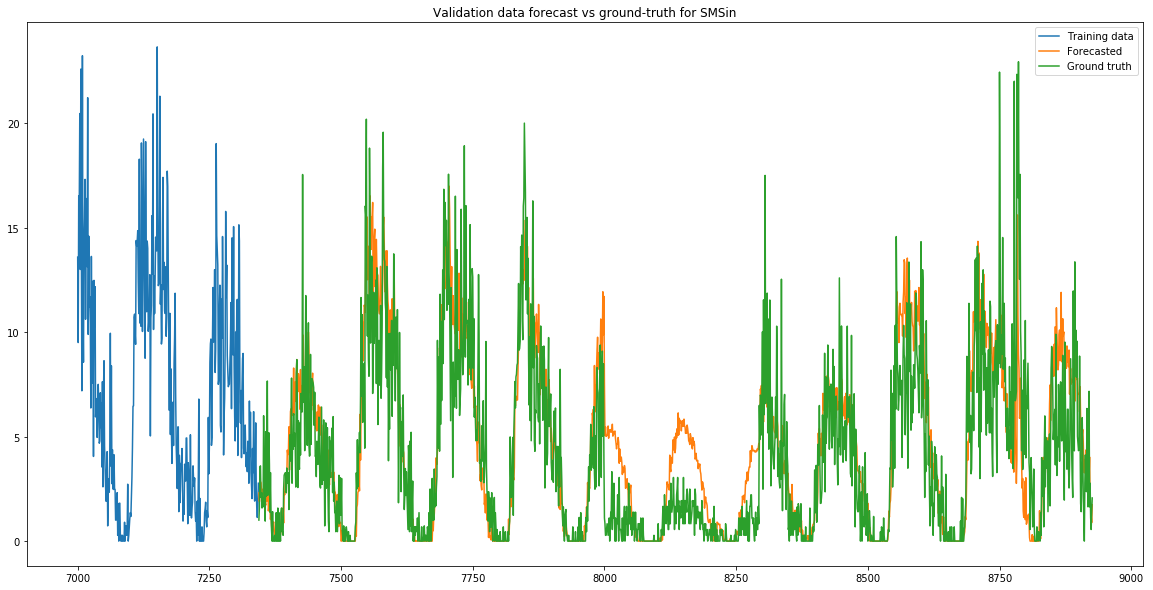

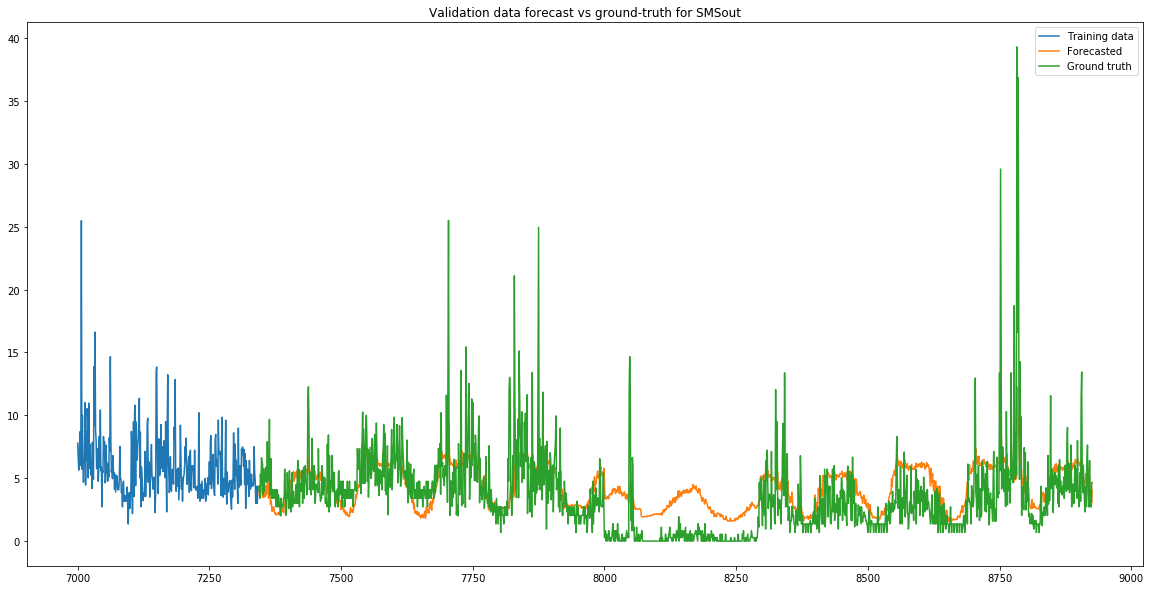

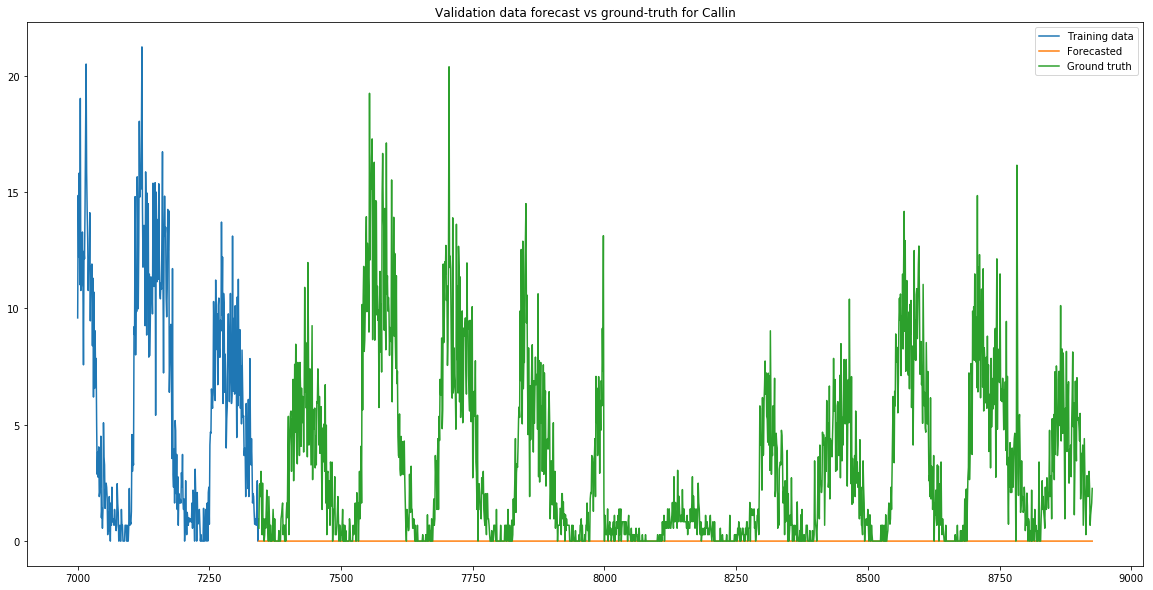

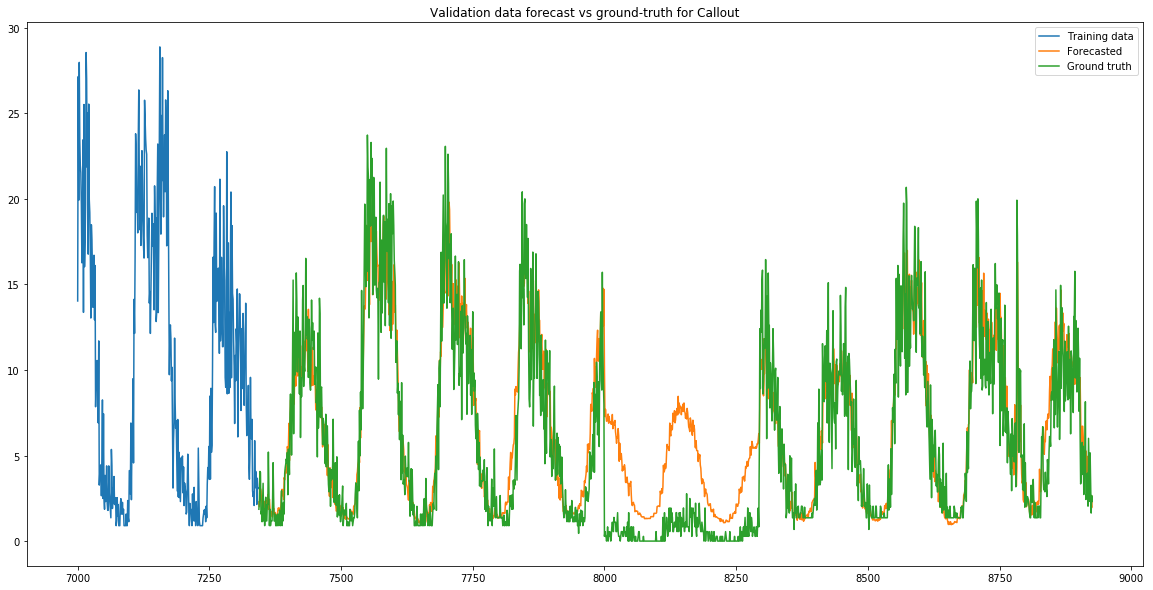

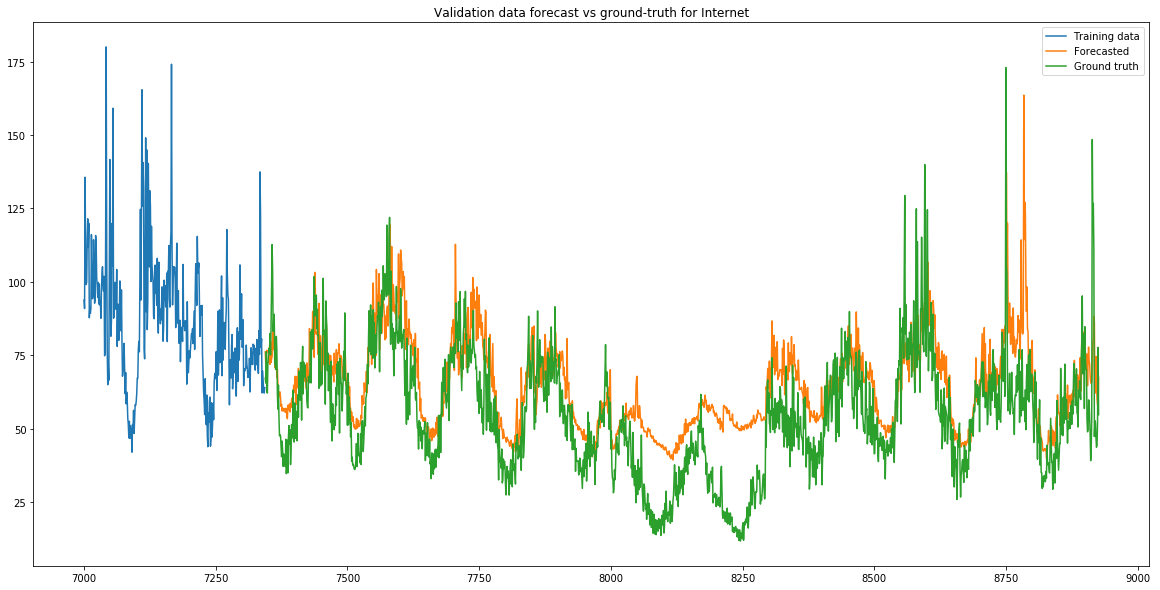

In [142]:
ground_train = dataset[["SMSin","SMSout","Callin","Callout","Internet"]].values[:n_ten_min,:]
start = 7000
for i, name in enumerate(["SMSin","SMSout","Callin","Callout","Internet"]) :
    plt.figure(figsize = (20,10))
    plt.plot(np.arange(start,train_y.shape[0]),ground_train[start:,i], label = "Training data")
    plt.plot(np.arange(train_y.shape[0],train_y.shape[0]+inv_yhat.shape[0]),forecast[i], label = "Forecasted")
    plt.plot(np.arange(train_y.shape[0],train_y.shape[0]+inv_yhat.shape[0]),ground_truth[i], label = "Ground truth")
    plt.title("Validation data forecast vs ground-truth for " + name)
    plt.legend()